## Solar twins

In [86]:
import numpy as np
from astropy.table import Table, unique
from astropy import units as u
from astropy.io import fits
import astropy.coordinates as coord
from astropy.time import Time
import matplotlib.pyplot as plt
import pandas as pd
import warnings
from astropy.utils.exceptions import AstropyWarning
warnings.simplefilter('ignore', category=AstropyWarning)

In [93]:
table_file = '../data/GAIA-ST.fits'
hdul = fits.open(table_file)
table = Table(hdul[1].data)

In [117]:
table['thick_disk_flag'] = False
thick = ['HIP19911', 'HIP108158', 'HIP109821', 'HIP115577', 
         'HIP14501 ', 'HIP28066 ', 'HIP30476 ',
        'HIP33094 ', 'HIP65708 ', 'HIP73241 ', 'HIP74432 ']
table['thick_disk_flag'][np.isin(table['id'], thick)] = True

In [154]:
table[table['astrometric_excess_noise'] > 0.0]['id']

HIP22263
HIP33094
HIP6407
HIP65708
HIP73241
HIP77052
HIP79578
HIP79672
HIP83276


### using Gala to transform into Galactic reference frame:

In [34]:
import gala.dynamics as gd
import gala.integrate as gi
import gala.potential as gp
from gala.units import galactic

In [36]:
mw  =  gp.MilkyWayPotential() # incl. disk, bulge, nucleus, halo
H = gp.Hamiltonian(mw)

In [37]:
rsun = 8.3 * u.kpc
vsun = [11.1, 232.24, 7.25] * u.km/u.s
gc_frame = coord.Galactocentric(galcen_distance=rsun,
                                galcen_v_sun=coord.CartesianDifferential(*vsun))

make SkyCoords objects for every solar twin (settin NaN RVs to zero so astropy doesn't bork):

In [38]:
table['radial_velocity'][np.isnan(table['radial_velocity'])] = 0.
gaia_time = Time('2015-01-01')
c = coord.SkyCoord(ra=np.array(table['ra'])*u.deg, 
                        dec=np.array(table['dec'])*u.deg, 
                        distance=(np.array(table['parallax'])*u.mas).to(u.pc, u.parallax()),
                        radial_velocity=np.array(table['radial_velocity'])*u.km/u.s,
                        pm_ra_cosdec=np.array(table['pmra'])*u.mas/u.yr, 
                        pm_dec=np.array(table['pmdec'])*u.mas/u.yr, 
                        obstime=gaia_time
                        )

now do the transformation:

In [28]:
w = gd.PhaseSpacePosition(c.transform_to(gc_frame).cartesian)

In [30]:
L = w.angular_momentum()
L_unit = u.km/u.s * u.kpc
Lz = L[2].to(L_unit).value

Text(0,0.5,'$L_z$ [$\\mathrm{km\\,kpc\\,s^{-1}}$]')

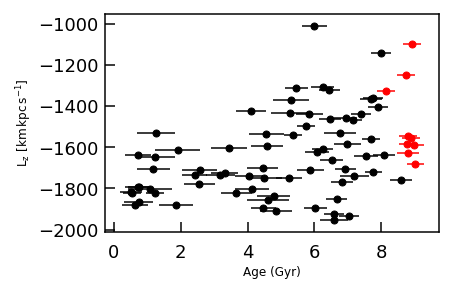

In [119]:
thin_ind = ~table['thick_disk_flag']
thick_ind = table['thick_disk_flag']
plt.scatter(table['age_mean'][thick_ind], Lz[thick_ind], c='r')
plt.errorbar(table['age_mean'][thick_ind], Lz[thick_ind], xerr=table['age_std'][thick_ind], 
             ls=' ', c='r')
plt.scatter(table['age_mean'][thin_ind], Lz[thin_ind], c='k')
plt.errorbar(table['age_mean'][thin_ind], Lz[thin_ind], xerr=table['age_std'][thin_ind], 
             ls=' ', c='k')
plt.xlabel('Age (Gyr)')
plt.ylabel('$L_z$ [{0:latex_inline}]'.format(L_unit))

### now let's integrate some orbits:

a lot of this code comes from [Adrian Price-Whelan](https://github.com/adrn/dr2-zero-day-happy-fun-time/blob/master/jay-z/Vertical-action-demo.ipynb)

In [49]:
from tqdm import tqdm
all_actions  = []
dts = [0.1, 0.2, 0.4, 0.8, 1., 2., 4, 8] * u.Myr

with warnings.catch_warnings(record=True):
    warnings.simplefilter("ignore")
    for dt in tqdm(dts):
        orbit = mw.integrate_orbit(w[0], dt=dt, t1=0*u.Gyr, t2=5*u.Gyr,
                                   Integrator=gi.DOPRI853Integrator)
        res = gd.actionangle.find_actions(orbit, N_max=8)
        all_actions.append(res['actions'])

100%|██████████| 8/8 [00:23<00:00,  2.99s/it]


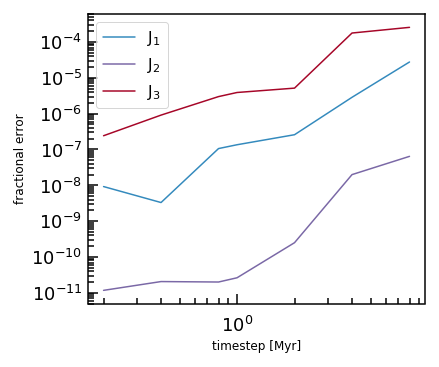

In [51]:

act  =  u.Quantity(all_actions)

plt.figure(figsize=(6, 5))

for k in range(3):
    plt.plot(dts[1:], np.abs((act[1:, k]-act[0, k])/act[0, k]), 
             label='$J_{0}$'.format(k+1))
    
plt.xscale('log')
plt.yscale('log')
plt.xlabel('timestep [Myr]')
plt.ylabel('fractional error')
plt.legend(loc='best', fontsize=16)
plt.tight_layout()

2 Myr seems like an ok timestep.

In [52]:
orbits = mw.integrate_orbit(w, dt=1*u.Myr, t1=0*u.Gyr, t2=4*u.Gyr,
                            Integrator=gi.DOPRI853Integrator)

with warnings.catch_warnings(record=True):
    warnings.simplefilter("ignore")

    all_actions = []
    for orbit in tqdm(orbits.orbit_gen(), total=w.shape[0]):
        res = gd.actionangle.find_actions(orbit, N_max=8)
        all_actions.append(res['actions'])
    all_actions = u.Quantity(all_actions)

100%|██████████| 78/78 [01:16<00:00,  1.03it/s]


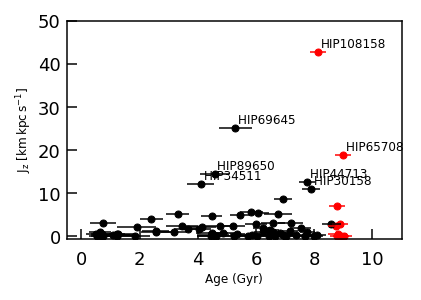

In [167]:
Jz = all_actions[:, 2].to(L_unit)
thin_ind = ~table['thick_disk_flag']
thick_ind = table['thick_disk_flag']
plt.scatter(table['age_mean'][thick_ind], Jz[thick_ind], c='r')
plt.errorbar(table['age_mean'][thick_ind], Jz.value[thick_ind], xerr=table['age_std'][thick_ind], 
             ls=' ', c='r')
plt.scatter(table['age_mean'][thin_ind], Jz[thin_ind], c='k')
plt.errorbar(table['age_mean'][thin_ind], Jz.value[thin_ind], xerr=table['age_std'][thin_ind], 
             ls=' ', c='k')
plt.xlabel('Age (Gyr)')
plt.ylabel('$J_z$ [{0:latex_inline}]'.format(L_unit))
for i,n in enumerate(table['id']):
    if Jz.value[i] > 9:
        plt.text(table['age_mean'][i]+0.1, Jz.value[i]+1, 
                 str(n), color='k', fontsize=12)
#plt.xscale('log')
#plt.yscale('log')
plt.xlim(-0.5, 11)
plt.ylim(-0.5, 50)
plt.savefig('vertical-actions.png')

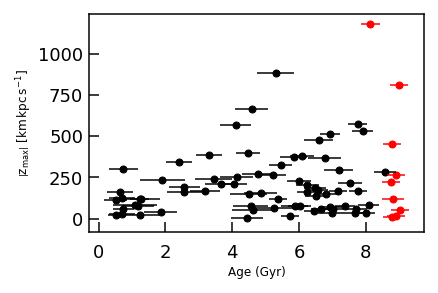

In [169]:
zmax = orbits.zmax(approximate=True).to(u.pc).value
plt.scatter(table['age_mean'][thick_ind], zmax[thick_ind], c='r')
plt.errorbar(table['age_mean'][thick_ind], zmax[thick_ind], xerr=table['age_std'][thick_ind], 
             ls=' ', c='r')
plt.scatter(table['age_mean'][thin_ind], zmax[thin_ind], c='k')
plt.errorbar(table['age_mean'][thin_ind], zmax[thin_ind], xerr=table['age_std'][thin_ind], 
             ls=' ', c='k')
plt.xlabel('Age (Gyr)')
plt.ylabel(r'$\left|z_{\rm max}\right|$ ' + '[{0:latex_inline}]'.format(L_unit))
plt.savefig('zmax.png')